# The prediction problem for this example scenerio is to estimate the probability that a machine will fail in the near future due to a failure of a certain component (there are four components)


# Step 1. Data Sources

Common data sources for predictive maintenance problems are :

* **Failure history:** The failure history of a machine or component within the machine.
* **Maintenance history:** The repair history of a machine, e.g. error codes, previous maintenance activities or component replacements.
* **Machine conditions and usage:** The operating conditions of a machine e.g. data collected from sensors.
* **Machine features:** The features of a machine, e.g. engine size, make and model, location.

The data for this example comes from 4 different sources which are real-time telemetry data collected from machines, error messages, historical maintenance records that include failures and machine information such as type and age.

In [43]:
import pandas as pd

telemetry = pd.read_csv('PdM_telemetry.csv')
errors = pd.read_csv('PdM_errors.csv')
maint = pd.read_csv('PdM_maint.csv')
failures = pd.read_csv('PdM_failures.csv')
machines = pd.read_csv('PdM_machines.csv')


## Step 2. Data Exploration 

In [44]:
# format datetime field which comes in as string
telemetry['datetime'] = pd.to_datetime(telemetry['datetime'], format="%Y-%m-%d %H:%M:%S")

print("Total number of telemetry records: %d" % len(telemetry.index))
print(telemetry.head())

telemetry.describe()



Total number of telemetry records: 876100
             datetime  machineID        volt      rotate    pressure  \
0 2015-01-01 06:00:00          1  176.217853  418.504078  113.077935   
1 2015-01-01 07:00:00          1  162.879223  402.747490   95.460525   
2 2015-01-01 08:00:00          1  170.989902  527.349825   75.237905   
3 2015-01-01 09:00:00          1  162.462833  346.149335  109.248561   
4 2015-01-01 10:00:00          1  157.610021  435.376873  111.886648   

   vibration  
0  45.087686  
1  43.413973  
2  34.178847  
3  41.122144  
4  25.990511  


,machineID,volt,rotate,pressure,vibration
count,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000
mean,50.500000,170.777736,446.605119,100.858668,40.385007
std,28.866087,15.509114,52.673886,11.048679,5.370361
min,1.000000,97.333604,138.432075,51.237106,14.877054
25%,25.750000,160.304927,412.305714,93.498181,36.777299
50%,50.500000,170.607338,447.558150,100.425559,40.237247
75%,75.250000,181.004493,482.176600,107.555231,43.784938
max,100.000000,255.124717,695.020984,185.951998,76.791072


In [45]:
telemetry.shape

(876100, 6)

#### **Telemetry**
The first data source is the telemetry time-series data which consists of **voltage, rotation, pressure, and vibration** measurements collected from 100 machines in **real time averaged over every hour collected during the year 2015**. Below, we plot the first month volt data of January

Text(0,0.5,'voltage')

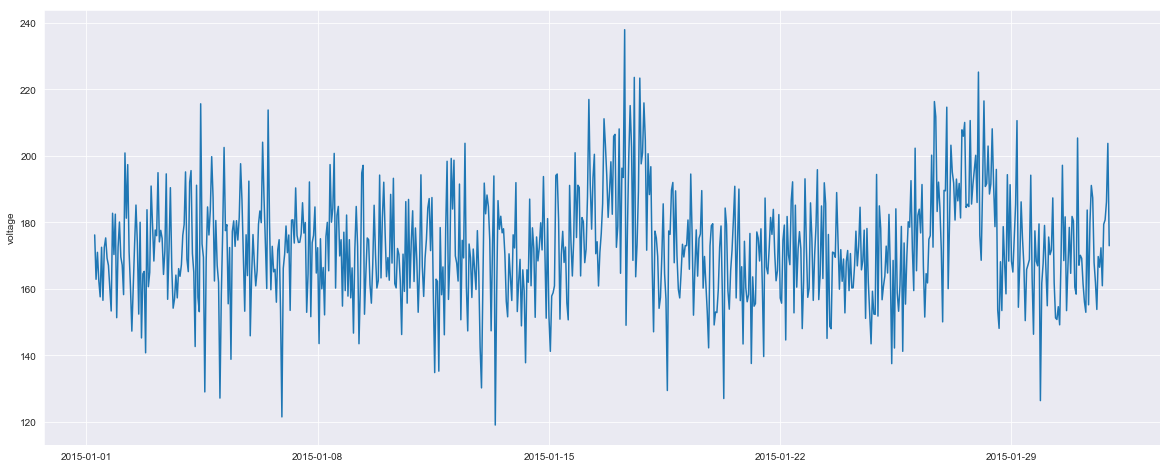

In [46]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# plot ONE machine - machineID == 1
# 
plot_df = telemetry.loc[(telemetry['machineID'] == 1) & 
                        (telemetry['datetime'] > pd.to_datetime('2015-01-01')) & 
                        (telemetry['datetime'] <pd.to_datetime('2015-02-01')),
                        ['datetime','volt']]
sns.set_style("darkgrid")
plt.figure(figsize=(20, 8))
plt.plot(plot_df['datetime'], plot_df['volt'])
plt.ylabel('voltage')



#### **Errors**
The second major data source is the error logs. These are **non-breaking errors thrown while the machine is still operational and do not constitute as failures.** The **error date and times** are rounded to the **closest hour** since the telemetry data is collected at an hourly rate.

In [47]:
errors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3919 entries, 0 to 3918
Data columns (total 3 columns):
datetime     3919 non-null object
machineID    3919 non-null int64
errorID      3919 non-null object
dtypes: int64(1), object(2)
memory usage: 91.9+ KB


In [48]:
# format of datetime field which comes in as string
errors['datetime'] = pd.to_datetime(errors['datetime'],format = '%Y-%m-%d %H:%M:%S')
errors['errorID'] = errors['errorID'].astype('category')
print("Total Number of error records: %d" %len(errors.index))
errors.head()


Total Number of error records: 3919


,datetime,machineID,errorID
0,2015-01-03 07:00:00,1,error1
1,2015-01-03 20:00:00,1,error3
2,2015-01-04 06:00:00,1,error5
3,2015-01-10 15:00:00,1,error4
4,2015-01-22 10:00:00,1,error4


error1    1010
error2     988
error3     838
error4     727
error5     356
Name: errorID, dtype: int64

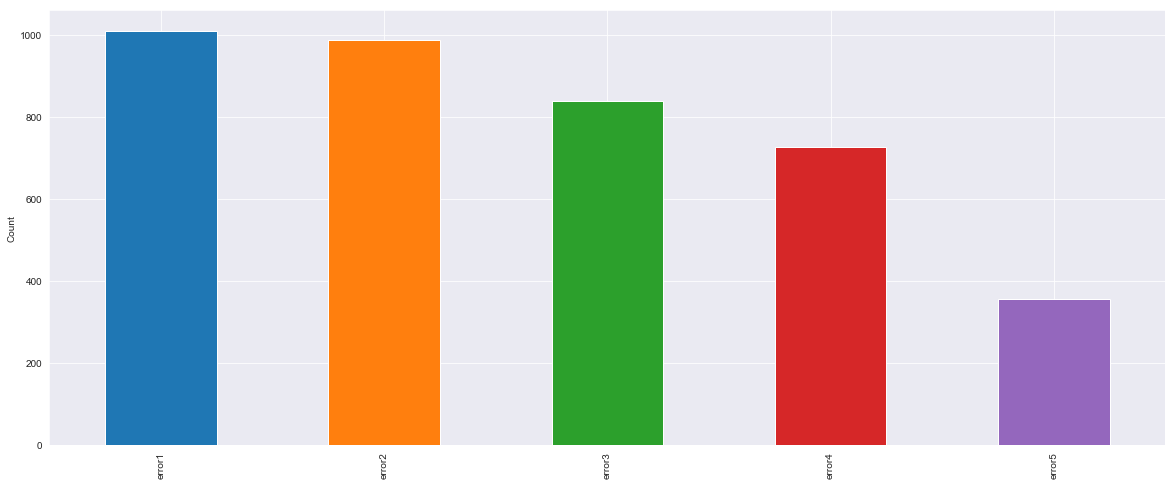

In [49]:
sns.set_style("darkgrid") #Controlling figure aesthetics
#Seaborn figure styles¶
#https://seaborn.pydata.org/tutorial/aesthetics.html
# There are five preset seaborn themes: darkgrid, whitegrid, dark, white, and ticks. 
#They are each suited to different applications and personal preferences.

plt.figure(figsize=(20, 8))
errors['errorID'].value_counts().plot(kind='bar')
plt.ylabel('Count')
errors['errorID'].value_counts()

#seaborn bar plot: 

#### **Maintenance**
These are the **scheduled and unscheduled** maintenance records which correspond to both **1) regular inspection of components as well as 2) failures.** A **record is generated if a component is replaced during the scheduled inspection or replaced due to a breakdown.** The **records that are created due to breakdowns will be called failures** which is explained in the later sections. Maintenance data has both 2014 and 2015 records.

In [50]:
maint['datetime'] = pd.to_datetime(maint['datetime'], format='%Y-%m-%d %H:%M:%S')
maint['comp'] = maint['comp'].astype('category')
print("Total Number of maintenance Records: %d" %len(maint.index))
maint.head()

Total Number of maintenance Records: 3286


,datetime,machineID,comp
0,2014-06-01 06:00:00,1,comp2
1,2014-07-16 06:00:00,1,comp4
2,2014-07-31 06:00:00,1,comp3
3,2014-12-13 06:00:00,1,comp1
4,2015-01-05 06:00:00,1,comp4


comp2    863
comp4    811
comp3    808
comp1    804
Name: comp, dtype: int64

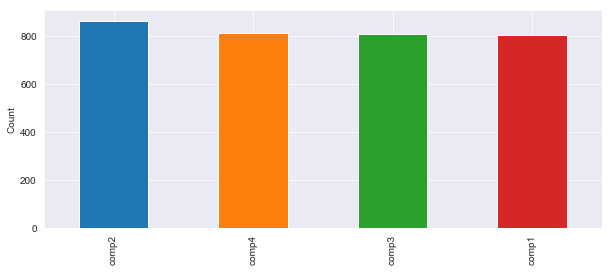

In [51]:
sns.set_style("darkgrid")
plt.figure(figsize=(10, 4))
maint['comp'].value_counts().plot(kind='bar')
plt.ylabel('Count')
maint['comp'].value_counts()

#https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.plot.html
# http://queirozf.com/entries/pandas-dataframe-plot-examples-with-matplotlib-pyplot

#### **Machines**
This data set includes some information about the machines: model type and age (years in service).

In [52]:
machines['model'] = machines['model'].astype('category')

print("Total number of machines: %d" % len(machines.index))
machines.head()

Total number of machines: 100


,machineID,model,age
0,1,model3,18
1,2,model4,7
2,3,model3,8
3,4,model3,7
4,5,model3,2


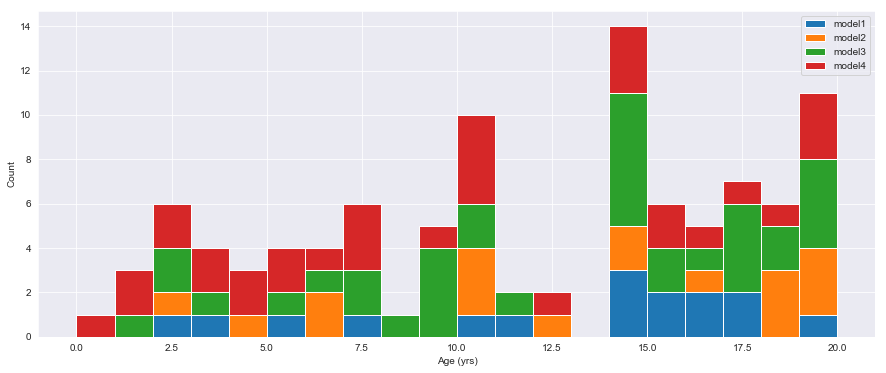

In [53]:
sns.set_style("darkgrid")
plt.figure(figsize=(15, 6))

# Find the number of machine models by various ages
plt.hist([machines.loc[machines['model'] == 'model1', 'age'],
                       machines.loc[machines['model'] == 'model2', 'age'],
                       machines.loc[machines['model'] == 'model3', 'age'],
                       machines.loc[machines['model'] == 'model4', 'age']],
                       20, stacked=True, label=['model1', 'model2', 'model3', 'model4'])
plt.xlabel('Age (yrs)')
plt.ylabel('Count')
plt.legend()


#plt.hist : 
# https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.hist.html

# Find the number of machine models by various ages


# Returns:	
# n : array or list of arrays
# The values of the histogram bins. See density and weights for a description of the possible semantics. If input x is an array, then this is an array of length nbins. If input is a sequence of arrays [data1, data2,..], then this is a list of arrays with the values of the histograms for each of the arrays in the same order. The dtype of the array n (or of its element arrays) will always be float even if no weighting or normalization is used.

# bins : array
# The edges of the bins. Length nbins + 1 (nbins left edges and right edge of last bin). Always a single array even when multiple data sets are passed in.

# patches : list or list of lists
# Silent list of individual patches used to create the histogram or list of such list if multiple input datasets.

#### **Failures**
These are the records of component replacements **due to failures.** Each record has a **date and time, machine ID, and failed component type.**

In [54]:
# format datetime field which comes in as string
failures['datetime'] = pd.to_datetime(failures['datetime'], format="%Y-%m-%d %H:%M:%S")
failures['failure'] = failures['failure'].astype('category')

print("Total number of failures: %d" % len(failures.index))
failures.head()

Total number of failures: 761


,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4


comp2    259
comp1    192
comp4    179
comp3    131
Name: failure, dtype: int64

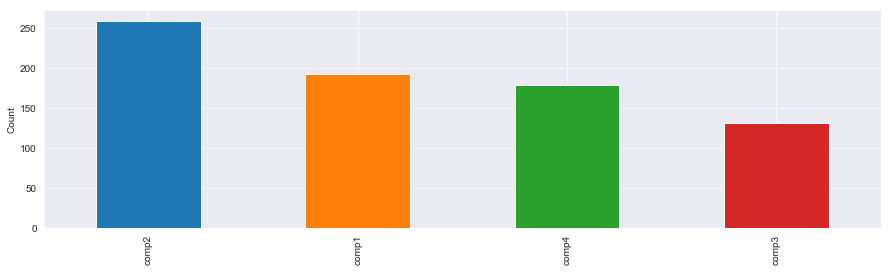

In [55]:
sns.set_style("darkgrid")
plt.figure(figsize=(15, 4))
failures['failure'].value_counts().plot(kind='bar')
plt.ylabel('Count')
failures['failure'].value_counts()

## Step 3. Feature Engineering
The first step in predictive maintenance applications is **feature engineering which requires bringing the different data sources together to create features that best describe a machines's health condition** at a given point in time. In the next sections, several feature engineering methods are used to create features based on the properties of each data source.

### Lag Features from Telemetry
Telemetry data almost always comes with time-stamps which makes it suitable for calculating lagging features. **A common method is to pick a window size for the lag features to be created and compute rolling aggregate measures such as mean, standard deviation, minimum, maximum, etc.** to represent the short term history of the telemetry over the lag window. In the following, **rolling mean and standard deviation of the telemetry data over the last 3 hour lag window is calculated for every 3 hours.**

In [56]:
telemetry.head()

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


In [57]:
# pivot table
pd.pivot_table(telemetry,
index='datetime',
columns='machineID',
values='volt')

#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.pivot_table.html

machineID,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
datetime,,,,,,,,,,,,,,,,,,,,,
2015-01-01 06:00:00,176.217853,176.558913,185.482043,169.710847,165.082899,136.878588,156.006391,159.379320,223.853296,158.421261,...,177.688355,159.446409,154.356894,175.639054,201.977168,155.273542,143.613163,153.300953,168.596133,161.587466
2015-01-01 07:00:00,162.879223,158.282044,179.818516,180.186857,192.783995,154.396864,216.913502,152.349153,153.106118,174.631951,...,173.426162,189.422834,158.261613,166.829717,171.602257,147.249491,169.258107,171.471504,153.667693,163.333175
2015-01-01 08:00:00,170.989902,168.242028,165.616803,156.861991,159.702056,151.995695,175.150525,196.751468,208.751664,158.777566,...,157.582897,162.088177,167.533443,166.130186,178.198293,176.628231,162.714703,170.773931,178.319255,153.926056
2015-01-01 09:00:00,162.462833,180.280316,165.007013,170.282492,162.706162,172.820648,168.268241,171.170268,188.851492,178.128852,...,139.092689,174.951013,169.745685,169.926452,164.762482,183.274022,166.069217,165.851737,162.163821,174.653605
2015-01-01 10:00:00,157.610021,169.719531,138.898164,187.487332,166.158350,181.469455,171.786580,155.323747,214.927439,176.497316,...,156.584252,183.651525,171.956004,167.610602,163.891788,180.739105,167.869939,175.140637,180.201336,199.637542
2015-01-01 11:00:00,172.504839,191.257247,171.100812,152.743067,162.393833,138.199503,155.495033,201.460403,170.479370,150.172656,...,191.022883,189.479179,179.787034,172.288218,159.119196,189.289609,145.147857,159.671007,171.918474,179.953141
2015-01-01 12:00:00,156.556031,186.282977,164.036698,189.708878,166.875641,165.390393,170.075486,137.210355,138.059938,183.765411,...,186.337840,171.933179,152.451205,149.372713,186.641477,145.260984,186.547641,168.617699,162.062405,159.291800
2015-01-01 13:00:00,172.522781,179.367188,152.967619,183.523486,206.533090,164.997856,187.464999,196.041618,184.703052,174.882596,...,179.071237,145.898434,184.794856,161.758101,189.557092,162.720708,173.623095,176.001037,166.071082,144.819444
2015-01-01 14:00:00,175.324524,168.893782,160.794446,151.152126,177.653319,170.204224,169.820240,148.989887,180.637889,158.551744,...,160.045013,168.344684,174.098976,178.474227,195.115459,179.738914,165.085469,181.171282,152.003845,181.439751


In [58]:
pd.pivot_table(telemetry,
               index='datetime',
               columns='machineID',
               values='volt').resample('3H', closed='left', label='right', how='mean').unstack()

#.resample = Resample time-series data

# Pivot a level of the (necessarily hierarchical) index labels, returning a DataFrame having a new level 
# of column labels whose inner-most level consists of the pivoted index labels.

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  after removing the cwd from sys.path.


machineID  datetime           
1          2015-01-01 09:00:00    170.028993
           2015-01-01 12:00:00    164.192565
           2015-01-01 15:00:00    168.134445
           2015-01-01 18:00:00    165.514453
           2015-01-01 21:00:00    168.809347
           2015-01-02 00:00:00    168.779396
           2015-01-02 03:00:00    172.277489
           2015-01-02 06:00:00    180.133784
           2015-01-02 09:00:00    176.364293
           2015-01-02 12:00:00    160.384568
           2015-01-02 15:00:00    170.472461
           2015-01-02 18:00:00    163.263806
           2015-01-02 21:00:00    163.278466
           2015-01-03 00:00:00    172.191198
           2015-01-03 03:00:00    175.210027
           2015-01-03 06:00:00    181.690108
           2015-01-03 09:00:00    172.382935
           2015-01-03 12:00:00    174.303858
           2015-01-03 15:00:00    176.246348
           2015-01-03 18:00:00    158.433533
           2015-01-03 21:00:00    162.387954
           2015-01-04 00

In [59]:
# Calculate mean values for telemetry features
temp = []
fields = ['volt', 'rotate', 'pressure', 'vibration']
for col in fields:
    temp.append(pd.pivot_table(telemetry,
                               index='datetime',
                               columns='machineID',
                               values=col).resample('3H', closed='left', label='right', how='mean').unstack())
telemetry_mean_3h = pd.concat(temp, axis=1)
telemetry_mean_3h.columns = [i + 'mean_3h' for i in fields]
telemetry_mean_3h.reset_index(inplace=True)

#Reset the index of the DataFrame, and use the default one instead. If the DataFrame has a MultiIndex, this method can remove one or more levels.


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  


In [60]:
telemetry_mean_3h.head()

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h
0,1,2015-01-01 09:00:00,170.028993,449.533798,94.592122,40.893502
1,1,2015-01-01 12:00:00,164.192565,403.949857,105.687417,34.255891
2,1,2015-01-01 15:00:00,168.134445,435.781707,107.793709,41.239405
3,1,2015-01-01 18:00:00,165.514453,430.472823,101.703289,40.373739
4,1,2015-01-01 21:00:00,168.809347,437.111120,90.911060,41.738542


In [61]:

# repeat for standard deviation
temp = []
for col in fields:
    temp.append(pd.pivot_table(telemetry,
                               index='datetime',
                               columns='machineID',
                               values=col).resample('3H', closed='left', label='right', how='std').unstack())
telemetry_sd_3h = pd.concat(temp, axis=1)
telemetry_sd_3h.columns = [i + 'sd_3h' for i in fields]
telemetry_sd_3h.reset_index(inplace=True)

telemetry_mean_3h.head()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).std()
  


,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h
0,1,2015-01-01 09:00:00,170.028993,449.533798,94.592122,40.893502
1,1,2015-01-01 12:00:00,164.192565,403.949857,105.687417,34.255891
2,1,2015-01-01 15:00:00,168.134445,435.781707,107.793709,41.239405
3,1,2015-01-01 18:00:00,165.514453,430.472823,101.703289,40.373739
4,1,2015-01-01 21:00:00,168.809347,437.111120,90.911060,41.738542


Next, the columns of the feature datasets created earlier are merged to create the final feature set from telemetry.

In [62]:
# merge columns of feature sets created earlier
telemetry_feat = pd.concat([telemetry_mean_3h,
                            telemetry_sd_3h.ix[:, 2:6]], axis=1).dropna()
telemetry_feat.describe()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


,machineID,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h
count,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000
mean,50.500000,170.777300,446.605807,100.858510,40.384920,13.299090,44.456338,8.885976,4.441164
std,28.866119,9.500846,33.130042,7.414517,3.478823,6.965914,23.216712,4.656211,2.320302
min,1.000000,125.532506,211.811184,72.118639,26.569635,0.025509,0.078991,0.027417,0.015278
25%,25.750000,164.449510,427.560977,96.238546,38.147765,8.027455,26.903705,5.370581,2.684790
50%,50.500000,170.434378,448.382261,100.234191,40.145837,12.495658,41.794719,8.346020,4.173955
75%,75.250000,176.611778,468.448505,104.406557,42.227559,17.688490,59.104130,11.790303,5.900106
max,100.000000,241.420717,586.682904,162.309656,69.311324,58.444332,179.903039,35.659369,18.305595


In [63]:
telemetry_feat.head()

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h
0,1,2015-01-01 09:00:00,170.028993,449.533798,94.592122,40.893502,6.721032,67.849599,18.934956,5.874970
1,1,2015-01-01 12:00:00,164.192565,403.949857,105.687417,34.255891,7.596570,50.120452,8.555032,7.662229
2,1,2015-01-01 15:00:00,168.134445,435.781707,107.793709,41.239405,10.124584,55.084734,5.909721,5.169304
3,1,2015-01-01 18:00:00,165.514453,430.472823,101.703289,40.373739,4.673269,42.047278,4.554047,2.106108
4,1,2015-01-01 21:00:00,168.809347,437.111120,90.911060,41.738542,14.752132,47.048609,4.244158,2.207884


### Lag Features from Errors
Like telemetry data, errors come with timestamps. An important difference is that the **error IDs are categorical values** and **should not be averaged over time intervals like the telemetry measurements.** Instead, we **count the number of errors of each type** in a **lagging window. We begin by reformatting the error data** to have one entry per machine per time at which at least one error occurred:

In [64]:
# create a column for each error type
error_count = pd.get_dummies(errors.set_index('datetime')).reset_index()
error_count
error_count.columns = ['datetime', 'machineID', 'error1', 'error2', 'error3', 'error4', 'error5']
error_count.head(10)


,datetime,machineID,error1,error2,error3,error4,error5
0,2015-01-03 07:00:00,1,1,0,0,0,0
1,2015-01-03 20:00:00,1,0,0,1,0,0
2,2015-01-04 06:00:00,1,0,0,0,0,1
3,2015-01-10 15:00:00,1,0,0,0,1,0
4,2015-01-22 10:00:00,1,0,0,0,1,0
5,2015-01-25 15:00:00,1,0,0,0,1,0
6,2015-01-27 04:00:00,1,1,0,0,0,0
7,2015-03-03 22:00:00,1,0,1,0,0,0
8,2015-03-05 06:00:00,1,1,0,0,0,0
9,2015-03-20 18:00:00,1,1,0,0,0,0


In [65]:
# combine errors for a given machine in a given hour
error_count = error_count.groupby(['machineID','datetime']).sum().reset_index()
error_count.head(10)


,machineID,datetime,error1,error2,error3,error4,error5
0,1,2015-01-03 07:00:00,1,0,0,0,0
1,1,2015-01-03 20:00:00,0,0,1,0,0
2,1,2015-01-04 06:00:00,0,0,0,0,1
3,1,2015-01-10 15:00:00,0,0,0,1,0
4,1,2015-01-22 10:00:00,0,0,0,1,0
5,1,2015-01-25 15:00:00,0,0,0,1,0
6,1,2015-01-27 04:00:00,1,0,0,0,0
7,1,2015-03-03 22:00:00,0,1,0,0,0
8,1,2015-03-05 06:00:00,1,0,0,0,0
9,1,2015-03-20 18:00:00,1,0,0,0,0


In [66]:
# merge the telemetry data with the error dataset
# telemetry data was collected in every hour but error dataset was collected sporadically
# this merging process ensures error dataset is mapped to the every hour datatime sequence

error_count = telemetry[['datetime', 'machineID']].merge(error_count, on=['datetime', 'machineID'], how='left').fillna(0.0)
error_count.describe()
error_count.shape

(876100, 7)

In [67]:
error_count.head()

,datetime,machineID,error1,error2,error3,error4,error5
0,2015-01-01 06:00:00,1,0.0,0.0,0.0,0.0,0.0
1,2015-01-01 07:00:00,1,0.0,0.0,0.0,0.0,0.0
2,2015-01-01 08:00:00,1,0.0,0.0,0.0,0.0,0.0
3,2015-01-01 09:00:00,1,0.0,0.0,0.0,0.0,0.0
4,2015-01-01 10:00:00,1,0.0,0.0,0.0,0.0,0.0


Finally, we can compute the **moving average of the number of errors of each type over the last 24 hours**, and take average for timepoints taken every three hours:

In [68]:
temp = []
fields = ['error%d' % i for i in range(1,6)]

for col in fields:
    temp.append(pd.pivot_table(error_count,index='datetime',columns='machineID',values=col).rolling(24).mean()
                .resample('3H',closed='left',label='right',how='mean').unstack())
    
   
error_count = pd.concat(temp, axis=1)
error_count.columns = [i + 'count' for i in fields]
error_count.reset_index(inplace=True)
error_count = error_count.dropna()
error_count.describe()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  


,machineID,error1count,error2count,error3count,error4count,error5count
count,291400.00000,291400.000000,291400.000000,291400.000000,291400.000000,291400.000000
mean,50.50000,0.001152,0.001128,0.000954,0.000829,0.000406
std,28.86612,0.006823,0.006753,0.006224,0.005775,0.004082
min,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.75000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,50.50000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,75.25000,0.000000,0.000000,0.000000,0.000000,0.000000
max,100.00000,0.083333,0.083333,0.083333,0.083333,0.083333


In [69]:
error_count.head()

,machineID,datetime,error1count,error2count,error3count,error4count,error5count
7,1,2015-01-02 06:00:00,0.0,0.0,0.0,0.0,0.0
8,1,2015-01-02 09:00:00,0.0,0.0,0.0,0.0,0.0
9,1,2015-01-02 12:00:00,0.0,0.0,0.0,0.0,0.0
10,1,2015-01-02 15:00:00,0.0,0.0,0.0,0.0,0.0
11,1,2015-01-02 18:00:00,0.0,0.0,0.0,0.0,0.0


## Machine Features
**The machine features can be used without further modification. These include descriptive information about the type of each machine and its age (number of years in service).** If the age information had been recorded as a "first use date" for each machine, a transformation would have been necessary to turn those into a numeric values indicating the years in service.

Lastly, we merge all the feature data sets we created earlier to get the final feature matrix.

In [70]:
telemetry_feat

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h
0,1,2015-01-01 09:00:00,170.028993,449.533798,94.592122,40.893502,6.721032,67.849599,18.934956,5.874970
1,1,2015-01-01 12:00:00,164.192565,403.949857,105.687417,34.255891,7.596570,50.120452,8.555032,7.662229
2,1,2015-01-01 15:00:00,168.134445,435.781707,107.793709,41.239405,10.124584,55.084734,5.909721,5.169304
3,1,2015-01-01 18:00:00,165.514453,430.472823,101.703289,40.373739,4.673269,42.047278,4.554047,2.106108
4,1,2015-01-01 21:00:00,168.809347,437.111120,90.911060,41.738542,14.752132,47.048609,4.244158,2.207884
5,1,2015-01-02 00:00:00,168.779396,486.242664,90.446472,41.796657,15.901952,36.129552,4.310741,9.390494
6,1,2015-01-02 03:00:00,172.277489,477.738628,89.104865,41.232001,6.884615,46.850076,9.205122,3.019906
7,1,2015-01-02 06:00:00,180.133784,440.608320,94.137969,41.551544,21.322735,48.770512,2.135684,10.037208
8,1,2015-01-02 09:00:00,176.364293,439.349655,101.553209,36.105580,18.952210,51.329636,13.789279,6.737739
9,1,2015-01-02 12:00:00,160.384568,424.385316,99.598722,36.094637,13.047080,13.702496,9.988609,1.639962


In [71]:
final_feat = telemetry_feat.merge(error_count, on=['datetime', 'machineID'], how='left')
final_feat = final_feat.merge(machines, on=['machineID'], how='left')

print(final_feat.head())
final_feat.describe()

   machineID            datetime  voltmean_3h  rotatemean_3h  pressuremean_3h  \
0          1 2015-01-01 09:00:00   170.028993     449.533798        94.592122   
1          1 2015-01-01 12:00:00   164.192565     403.949857       105.687417   
2          1 2015-01-01 15:00:00   168.134445     435.781707       107.793709   
3          1 2015-01-01 18:00:00   165.514453     430.472823       101.703289   
4          1 2015-01-01 21:00:00   168.809347     437.111120        90.911060   

   vibrationmean_3h  voltsd_3h  rotatesd_3h  pressuresd_3h  vibrationsd_3h  \
0         40.893502   6.721032    67.849599      18.934956        5.874970   
1         34.255891   7.596570    50.120452       8.555032        7.662229   
2         41.239405  10.124584    55.084734       5.909721        5.169304   
3         40.373739   4.673269    42.047278       4.554047        2.106108   
4         41.738542  14.752132    47.048609       4.244158        2.207884   

   error1count  error2count  error3count  er

,machineID,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,error1count,error2count,error3count,error4count,error5count,age
count,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,292000.000000
mean,50.500000,170.777300,446.605807,100.858510,40.384920,13.299090,44.456338,8.885976,4.441164,0.001152,0.001128,0.000954,0.000829,0.000406,11.330000
std,28.866119,9.500846,33.130042,7.414517,3.478823,6.965914,23.216712,4.656211,2.320302,0.006824,0.006754,0.006223,0.005776,0.004082,5.827625
min,1.000000,125.532506,211.811184,72.118639,26.569635,0.025509,0.078991,0.027417,0.015278,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.750000,164.449510,427.560977,96.238546,38.147765,8.027455,26.903705,5.370581,2.684790,0.000000,0.000000,0.000000,0.000000,0.000000,6.750000
50%,50.500000,170.434378,448.382261,100.234191,40.145837,12.495658,41.794719,8.346020,4.173955,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000
75%,75.250000,176.611778,468.448505,104.406557,42.227559,17.688490,59.104130,11.790303,5.900106,0.000000,0.000000,0.000000,0.000000,0.000000,16.000000
max,100.000000,241.420717,586.682904,162.309656,69.311324,58.444332,179.903039,35.659369,18.305595,0.083333,0.083333,0.083333,0.083333,0.083333,20.000000


# Label Construction
When using **multi-class classification for predicting failure due to a problem**, labelling is done by taking a time window prior to the failure of an asset and labelling the feature records that fall into that window as "about to fail due to a problem" while labelling all other records as "Â€Âœnormal." This time window should be picked according to the business case: in some situations it may be enough to predict failures hours in advance, while in others days or weeks may be needed to allow e.g. for arrival of replacement parts.

The prediction problem for this example scenerio is to **estimate the probability that a machine will fail in the near future due to a failure of a certain component**. More specifically, the goal is to compute the probability that a machine will fail in the next 24 hours due to a certain component failure (component 1, 2, 3, or 4). **Below, a categorical failure feature is created to serve as the label**. All records within a 24 hour window before a failure of component 1 have failure=comp1, and so on for components 2, 3, and 4; all records not within 24 hours of a component failure have failure=none.

In [72]:
failures.head(20)

,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4
5,2015-10-17 06:00:00,1,comp2
6,2015-12-16 06:00:00,1,comp4
7,2015-03-19 06:00:00,2,comp1
8,2015-03-19 06:00:00,2,comp2
9,2015-04-18 06:00:00,2,comp2


In [73]:
labeled_features = final_feat.merge(failures, on=['datetime', 'machineID'], how='left')

labeled_features.head()

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,error1count,error2count,error3count,error4count,error5count,model,age,failure
0,1,2015-01-01 09:00:00,170.028993,449.533798,94.592122,40.893502,6.721032,67.849599,18.934956,5.874970,NaN,NaN,NaN,NaN,NaN,model3,18,NaN
1,1,2015-01-01 12:00:00,164.192565,403.949857,105.687417,34.255891,7.596570,50.120452,8.555032,7.662229,NaN,NaN,NaN,NaN,NaN,model3,18,NaN
2,1,2015-01-01 15:00:00,168.134445,435.781707,107.793709,41.239405,10.124584,55.084734,5.909721,5.169304,NaN,NaN,NaN,NaN,NaN,model3,18,NaN
3,1,2015-01-01 18:00:00,165.514453,430.472823,101.703289,40.373739,4.673269,42.047278,4.554047,2.106108,NaN,NaN,NaN,NaN,NaN,model3,18,NaN
4,1,2015-01-01 21:00:00,168.809347,437.111120,90.911060,41.738542,14.752132,47.048609,4.244158,2.207884,NaN,NaN,NaN,NaN,NaN,model3,18,NaN


In [74]:
# labeled_features = labeled_features.fillna(method='bfill', limit=7) # fill backward up to 24h
# labeled_features = labeled_features.fillna('none')
labeled_features['error1count'] = labeled_features['error1count'].fillna(0)
labeled_features['error2count'] = labeled_features['error1count'].fillna(0)
labeled_features['error3count'] = labeled_features['error1count'].fillna(0)
labeled_features['error4count'] = labeled_features['error1count'].fillna(0)
labeled_features['error5count'] = labeled_features['error1count'].fillna(0)

labeled_features.head(10)

print(labeled_features['failure'].value_counts())
labeled_features.shape

comp2    259
comp1    192
comp4    179
comp3    131
Name: failure, dtype: int64


(292042, 18)

Below is an example of records that are labeled as failure=comp4 in the failure column.

In [75]:
labeled_features.loc[labeled_features['failure'] == 'comp4']

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,error1count,error2count,error3count,error4count,error5count,model,age,failure
31,1,2015-01-05 06:00:00,185.782709,439.531288,99.413660,51.558082,14.495664,45.663743,4.289212,7.330397,0.000000,0.000000,0.000000,0.000000,0.000000,model3,18,comp4
1351,1,2015-06-19 06:00:00,172.059069,463.242610,96.905050,53.701413,14.757880,55.874000,3.204981,2.329615,0.000000,0.000000,0.000000,0.000000,0.000000,model3,18,comp4
1951,1,2015-09-02 06:00:00,165.530175,413.547130,103.631528,60.142846,9.088618,49.918671,14.438808,5.389723,0.000000,0.000000,0.000000,0.000000,0.000000,model3,18,comp4
2791,1,2015-12-16 06:00:00,188.941806,421.756494,86.684047,51.410144,35.295874,7.839110,9.139511,3.598700,0.000000,0.000000,0.000000,0.000000,0.000000,model3,18,comp4
17705,7,2015-01-24 06:00:00,177.669082,361.502737,109.447331,46.975392,8.531048,29.773424,4.384169,5.187506,0.000000,0.000000,0.000000,0.000000,0.000000,model3,20,comp4
18545,7,2015-05-09 06:00:00,175.911702,467.458682,103.589910,52.610306,12.400140,69.604586,11.162580,1.658487,0.000000,0.000000,0.000000,0.000000,0.000000,model3,20,comp4
19625,7,2015-09-21 06:00:00,169.123329,428.763286,99.428189,45.397202,21.723826,100.568119,22.697296,3.416446,0.000000,0.000000,0.000000,0.000000,0.000000,model3,20,comp4
21081,8,2015-03-22 06:00:00,173.026438,429.852151,102.408383,54.340943,11.452078,42.822464,11.195405,7.115879,0.000000,0.000000,0.000000,0.000000,0.000000,model3,16,comp4
22161,8,2015-08-04 06:00:00,178.611054,425.076676,102.481539,48.617995,12.652412,22.014775,18.517554,2.918507,0.000000,0.000000,0.000000,0.000000,0.000000,model3,16,comp4
22761,8,2015-10-18 06:00:00,166.642406,452.842842,104.470047,52.080654,5.920407,46.523492,5.792959,4.005665,0.000000,0.000000,0.000000,0.000000,0.000000,model3,16,comp4


In [76]:
labeled_features = labeled_features.dropna()
labeled_features.shape

(761, 18)

# Modelling
After the feature engineering and labelling steps, this notebook can be used to create a predictive model. Below, we describe the modelling process and provide an example Python model.

# Training, Validation and Testing
When working with time-stamped data as in this example, record partitioning into training, validation, and test sets should be performed carefully to prevent overestimating the performance of the models. In predictive maintenance, the features are usually generated using lagging aggregates: records in the same time window will likely have identical labels and similar feature values. These correlations can give a model an "unfair advantage" when predicting on a test set record that shares its time window with a training set record. We therefore partition records into training, validation, and test sets in large chunks, to minimize the number of time intervals shared between them.

Predictive models have no advance knowledge of future chronological trends: in practice, such trends are likely to exist and to adversely impact the model's performance. To obtain an accurate assessment of a predictive model's performance, we recommend training on older records and validating/testing using newer records.


In [77]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split

# split out training and test data
y = labeled_features.loc[:,'failure']
X = pd.get_dummies(labeled_features.drop(['datetime','machineID','failure'], 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

my_model = GradientBoostingClassifier(random_state=42)
my_model.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=42,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [78]:
my_model.feature_importances_

array([1.31730953e-02, 2.41213246e-01, 1.88316327e-01, 2.38322294e-01,
       6.02983907e-03, 6.78575938e-03, 8.97488611e-03, 7.56876855e-03,
       1.99026735e-02, 7.20900765e-02, 2.72944720e-02, 7.72931773e-03,
       1.26070946e-01, 1.24016539e-02, 1.82520932e-03, 3.15113850e-05,
       2.08789079e-02, 1.39101664e-03])

Text(0,0.5,'Importance')

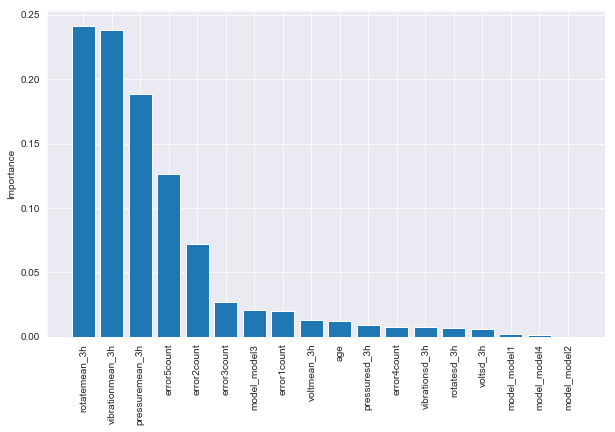

In [79]:
sns.set_style("darkgrid")
plt.figure(figsize=(10, 6))

#The zip() function returns an iterator of tuples based on the iterable object.
labels, importances = zip(*sorted(zip(X_train.columns, my_model.feature_importances_), reverse=True, key=lambda x: x[1]))
# labels are the features
# importances are the importance values of labels

plt.xticks(range(len(labels)), labels)
_, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.bar(range(len(importances)), importances)
plt.ylabel('Importance')

In [80]:
test_results = my_model.predict(test_X)

test_results



array(['comp2', 'comp4', 'comp2', 'comp2', 'comp2', 'comp2', 'comp2',
       'comp1', 'comp2', 'comp1', 'comp4', 'comp2', 'comp1', 'comp2',
       'comp3', 'comp3', 'comp2', 'comp1', 'comp4', 'comp1', 'comp1',
       'comp2', 'comp2', 'comp4', 'comp3', 'comp3', 'comp3', 'comp3',
       'comp2', 'comp1', 'comp4', 'comp4', 'comp1', 'comp2', 'comp3',
       'comp2', 'comp1', 'comp4', 'comp2', 'comp4', 'comp2', 'comp3',
       'comp3', 'comp4', 'comp3', 'comp4', 'comp3', 'comp4', 'comp3',
       'comp4', 'comp3', 'comp2', 'comp4', 'comp2', 'comp1', 'comp2',
       'comp1', 'comp2', 'comp4', 'comp2', 'comp1', 'comp1', 'comp1',
       'comp1', 'comp2', 'comp1', 'comp4', 'comp2', 'comp3', 'comp4',
       'comp4', 'comp4', 'comp2', 'comp2', 'comp1', 'comp3', 'comp1',
       'comp2', 'comp3', 'comp4', 'comp1', 'comp2', 'comp4', 'comp1',
       'comp2', 'comp2', 'comp2', 'comp2', 'comp2', 'comp4', 'comp3',
       'comp2', 'comp4', 'comp2', 'comp4', 'comp2', 'comp1', 'comp1',
       'comp4', 'com